# Atelier 2 : Données manquantes, biais, déséquilibres de classes
Dans ce TP, nous allons explorer plusieurs étapes cruciales pour la préparation de données avant leur utilisation dans un modèle de machine learning. Nous utiliserons des données hospitalières pour illustrer les concepts abordés.

N'oubliez pas d'explorer la documentation pour chaque fonction que vous utilisez et d'approfondir vos connaissances sur chaque méthode !
> **Ressources utiles** :
> - [Documentation de Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)
> - [Documentation de Scikit-learn](https://scikit-learn.org/stable/documentation.html)
> - [Documentation de Imbalanced-learn](https://imbalanced-learn.org/stable/index.html)

##### 🔄 Chargement des données
Commençons par charger les jeux de données JSON et CSV fournis. Nous utiliserons la bibliothèque `pandas` pour cela.

> **Astuce** : Consultez la [documentation de pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) si vous avez des doutes sur les options de la fonction `read_csv`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer

%matplotlib inline

df = pd.read_csv("diabetes_custom.csv")  

df.head()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Weight                    757 non-null    float64
 9   Height                    768 non-null    float64
 10  Country                   768 non-null    object 
 11  Outcome                   768 non-null    int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 72.1+ KB


##### 📈 Visualiser la distribution des données
Utilisez la méthode `hist()` de la classe DataFrame pour afficher l'histogramme des différentes colonnes des jeux de données.

❓ **Question** : Que remarquez-vous d'anormal ?

La distribution de plusieurs variables est asymétrique (par exemple, l'insuline et l'IMC).

On observe des valeurs aberrantes pour l'insuline, le poids, etc.

La variable de résultat est déséquilibrée (environ 65 % de la classe 0 et environ 35 % de la classe 1).

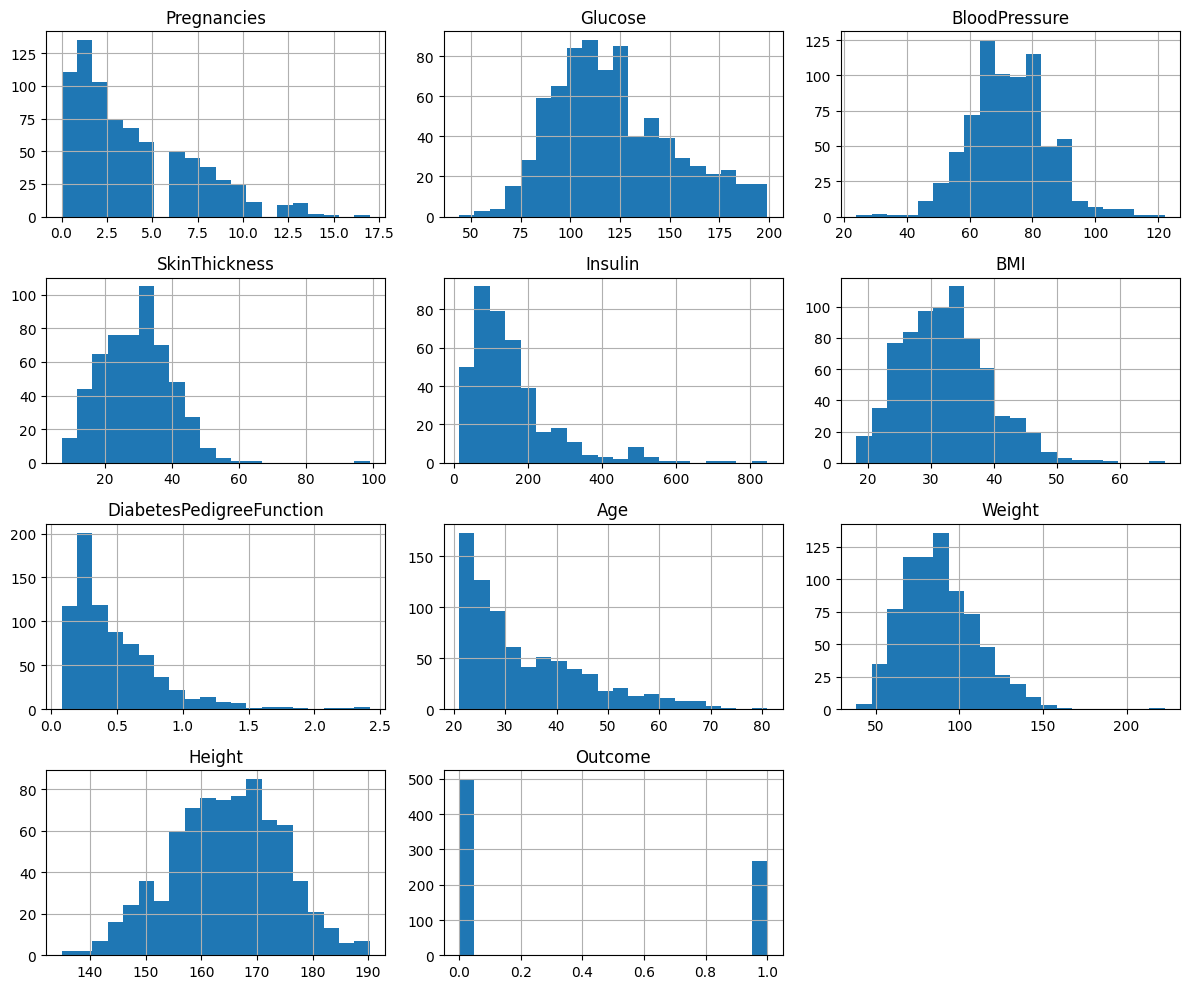

In [ ]:
# A compléter
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()


#### 🏷️ Étape 1 : Gestion des Variables Catégorielles
Convertir les variables catégorielles en variables numériques à l'aide de techniques telles que le `OneHotEncoding` et le `LabelEncoding`.

❓ **Question** : Dans notre cas, quelle méthode privilégier ? Pourquoi

OneHotEncoding est préférable ici car la variable « Country » ne suit pas un ordre naturel (France, India, USA).

LabelEncoding introduit un ordre artificiel (0, 1, 2) que les modèles linéaires peuvent interpréter comme ordinal.

In [5]:
# OneHotEncoding
# A compléter
df_encoded = pd.get_dummies(df, columns=['Country'], drop_first=False)
df_encoded.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Weight,Height,Outcome,Country_France,Country_India,Country_USA
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,97.42,170.28,1,False,True,False
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,69.10,161.18,0,False,False,True
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,55.74,154.67,1,False,True,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,85.94,174.88,0,True,False,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,122.27,168.43,1,False,True,False


In [6]:
# LabelEncoding
# A compléter
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_label_encoded = df.copy()
df_label_encoded['Country'] = le.fit_transform(df_label_encoded['Country'])
df_label_encoded.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Weight,Height,Country,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,97.42,170.28,1,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,69.10,161.18,2,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,55.74,154.67,1,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,85.94,174.88,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,122.27,168.43,1,1


#### 🔧 Complétion des valeurs manquantes
Il est courant de rencontrer des valeurs manquantes dans les jeux de données. Dans cette section, il vous est demandé de traiter le problème avec différentes méthodes :

1. **Suppression des lignes avec valeurs manquantes**
   Écrivez une fonction qui vous permet de supprimer les lignes contenant des valeurs nulles. Utilisez la méthode `dropna` de la classe DataFrame.  
   ❓ **Question** : Comparez la taille des jeux de données avant et après retrait des individus présentant des valeurs manquantes. Quelles sont les limites de cette méthode ?

   Avant : 768 lignes ; après suppression des valeurs manquantes : 392 lignes.

   Problème : près de la moitié des données sont perdues, perte d'informations et risque de biais (les femmes présentant des données manquantes ne sont pas sélectionnées aléatoirement).

2. **Remplacement par la moyenne/médiane/mode**
   Remplacez les valeurs NaN par la moyenne observée dans la colonne.

3. **Interpolation linéaire**
   Utilisez la méthode `interpolate()` de la classe `Serie` pour compléter les valeurs manquantes.  
   ❓ **Question** : Que fait exactement la méthode `interpolate()` ? (Référez-vous à la documentation de pandas)

4. **Imputation des valeurs par méthode K-Nearest Neighbour (KNN)**
   Utilisez la classe `KNNImputer` de la bibliothèque sklearn pour compléter les valeurs manquantes.  
   ❓ **Question** : Que fait exactement cette méthode ? (Référez-vous à la documentation de pandas)

**Note** : Certaines de ces méthodes convertissent les colonnes exprimées à travers des valeurs entières en flottants. Assurez-vous de convertir manuellement les colonnes concernées (Pregnancies, Age, etc.) en entiers après coup.

In [7]:
# Afficher un aperçu des valeurs manquantes (méthode isna())
# A compléter
df_encoded.isna().sum()

na_columns = df_encoded.columns[df_encoded.isna().any()].tolist()
na_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Weight']

In [30]:
# 1. Suppression des lignes avec valeurs manquantes
# A compléter
def drop_na_rows(df, cols):
    return df.dropna(subset=cols)

df_dropped = drop_na_rows(df_encoded, na_columns)
df.shape, df_dropped


((768, 12),
      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 3              1     89.0           66.0           23.0     94.0  28.1   
 4              0    137.0           40.0           35.0    168.0  43.1   
 6              3     78.0           50.0           32.0     88.0  31.0   
 8              2    197.0           70.0           45.0    543.0  30.5   
 13             1    189.0           60.0           23.0    846.0  30.1   
 ..           ...      ...            ...            ...      ...   ...   
 753            0    181.0           88.0           44.0    510.0  43.3   
 755            1    128.0           88.0           39.0    110.0  36.5   
 760            2     88.0           58.0           26.0     16.0  28.4   
 763           10    101.0           76.0           48.0    180.0  32.9   
 765            5    121.0           72.0           23.0    112.0  26.2   
 
      DiabetesPedigreeFunction  Age  Weight  Height  Outcome  Country_France  \
 3    

In [16]:
# 2. Remplacement par la moyenne/médiane
def fill_na(df, cols):
    int_columns = df.select_dtypes(include='int').columns.tolist()
    df_filled = df.copy()
    for col in cols:
        if df[col].dtype.kind in "biufc":  
            value = df[col].median()
        else:
            value = df[col].mode()[0]
        df_filled[col] = df_filled[col].fillna(value)
        
    df_filled[int_columns] = df[int_columns].round(0).astype(int)

    return df_filled

df_filled = fill_na(df_encoded, na_columns)
df_filled



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Weight,Height,Outcome,Country_France,Country_India,Country_USA
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,97.42,170.28,1,False,True,False
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,69.10,161.18,0,False,False,True
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,55.74,154.67,1,False,True,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,85.94,174.88,0,True,False,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,122.27,168.43,1,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,97.90,172.50,0,True,False,False
764,2,122.0,70.0,27.0,125.0,36.8,0.340,27,110.49,173.27,0,True,False,False
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,73.20,167.15,0,False,True,False
766,1,126.0,60.0,29.0,125.0,30.1,0.349,47,94.50,177.19,1,True,False,False


In [17]:
# 3. Interpolation linéaire pour les valeurs manquantes
def interpolate(df, cols):
    int_columns = df.select_dtypes(include='int').columns.tolist()
    df_interpolated = df.copy()
    for col in cols:
        df_interpolated[col] = df_interpolated[col].interpolate(method='linear')
        df_interpolated[col] = df_interpolated[col].fillna(df[col].median())

    df_interpolated[int_columns] = df[int_columns].round(0).astype(int)
    
    return df_interpolated

df_interpolated = interpolate(df_encoded, na_columns)

df_interpolated


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Weight,Height,Outcome,Country_France,Country_India,Country_USA
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,97.42,170.28,1,False,True,False
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,69.10,161.18,0,False,False,True
2,8,183.0,64.0,26.0,125.0,23.3,0.672,32,55.74,154.67,1,False,True,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,85.94,174.88,0,True,False,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,122.27,168.43,1,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,97.90,172.50,0,True,False,False
764,2,122.0,70.0,27.0,146.0,36.8,0.340,27,110.49,173.27,0,True,False,False
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,73.20,167.15,0,False,True,False
766,1,126.0,60.0,27.0,112.0,30.1,0.349,47,94.50,177.19,1,True,False,False


In [18]:
# 4. Imputation KNN

def data_imputation(df, cols = []):
    int_columns = df.select_dtypes(include='int').columns.tolist()
    df_imputed = df.copy()
    if not cols:
        cols = df_imputed.columns[df_imputed.isna().any()].tolist()
    imputer = KNNImputer(n_neighbors=5)
    df_imputed[cols] = imputer.fit_transform(df_imputed[cols])

    df_imputed[int_columns] = df_imputed[int_columns].round(0).astype(int)

    return df_imputed

df_imputed = data_imputation(df_encoded, na_columns)
df_imputed


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Weight,Height,Outcome,Country_France,Country_India,Country_USA
0,6,148.0,72.0,35.0,203.4,33.6,0.627,50,97.42,170.28,1,False,True,False
1,1,85.0,66.0,29.0,78.6,26.6,0.351,31,69.10,161.18,0,False,False,True
2,8,183.0,64.0,24.4,236.4,23.3,0.672,32,55.74,154.67,1,False,True,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,85.94,174.88,0,True,False,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,122.27,168.43,1,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,97.90,172.50,0,True,False,False
764,2,122.0,70.0,27.0,135.2,36.8,0.340,27,110.49,173.27,0,True,False,False
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,73.20,167.15,0,False,True,False
766,1,126.0,60.0,21.8,130.4,30.1,0.349,47,94.50,177.19,1,True,False,False


#### 📊 Biais d'outlier et détection des valeurs aberrantes
Certains modèles d'intelligence artificielle sont très sensibles à la présence d'individus qui sont éloignés de la moyenne du jeux de données (Outliers). Une tâche préalable consiste donc à détecter et supprimer ces individus. Pour détecter des outliers, différents algorithmes peuvent être utilisés. Ici nous utiliserons une simple méthode statistique, consistant à déterminer, sur chaque dimension, si un outlier est au-delà de 2 ecart-types. 

1. Ecrire une fonction qui ajoute une colonne à un dataframe indiquant le nombre de dimension pour lequel chaque individu peut-être considéré comme un outlier.
2. Ecrire une fonction qui élimine les individus ayant plus de 3 dimensions trop éloignées de la moyenne.

In [ ]:
def detect_outliers(df, num_std=2, threshold=1):
    numeric_df = df.select_dtypes(include=[np.number])
    z_scores = np.abs(stats.zscore(numeric_df))
    outlier_mask = (z_scores > num_std).sum(axis=1) >= threshold
    return df[outlier_mask]


def remove_outliers(df, threshold):
    numeric_df = df.select_dtypes(include=[np.number])
    z_scores = np.abs(stats.zscore(numeric_df))
    outlier_mask = (z_scores > threshold).any(axis=1)
    return df[~outlier_mask]


df_outliers = remove_outliers(df_imputed, 2)
df_imputed



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Weight,Height,Outcome,Country_France,Country_India,Country_USA
0,6,148.0,72.0,35.0,203.4,33.6,0.627,50,97.42,170.28,1,False,True,False
1,1,85.0,66.0,29.0,78.6,26.6,0.351,31,69.10,161.18,0,False,False,True
2,8,183.0,64.0,24.4,236.4,23.3,0.672,32,55.74,154.67,1,False,True,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,85.94,174.88,0,True,False,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,122.27,168.43,1,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,97.90,172.50,0,True,False,False
764,2,122.0,70.0,27.0,135.2,36.8,0.340,27,110.49,173.27,0,True,False,False
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,73.20,167.15,0,False,True,False
766,1,126.0,60.0,21.8,130.4,30.1,0.349,47,94.50,177.19,1,True,False,False


#### ⚖️ Gestion du Déséquilibre de Classe

Le jeu de données peut présenter un déséquilibre dans les classes de la variable `Outcome`. Cela signifie qu'une classe peut être beaucoup plus représentée que l'autre, ce qui a pour effet de biaiser les modèles prédictifs en favorisant les prédictions vers la classe sur-représentée. Dans notre cas, la colonne `Outcome`, qui traduit le résultat d'un diagnostic présente un déséquilibre de représentation. Les performances d'un modèle visant à prédire le diagnostic d'un patient sur la base des autres colonnes du dataset seront nécessairement affectées par ce déséquilibre. Nous allons explorer plusieurs techniques pour traiter ce problème :

1. **Undersampling** : Réduction des individus de la classe majoritaire par suppression d'individus.
2. **Oversampling** : Génération de nouveaux individus de la classe minoritaire par échantillonage avec remise sur les individus existantes.
3. **SMOTE** (Synthetic Minority Over-sampling Technique) : Génération d'individus synthétiques de la classe minoritaire dans le voisinage des instances existantes.

Afficher la distribution des classes pour constater le déséquilibre

A partir du code fonurni ci-dessous, écrire trois fonctions réalisant l'oversampling, l'undersampling et appliquant la méthode SMOTE. Pour cela, vous pourrez utiliser la fonction `resample` de la bibliothèque `sklearn.utils` qui permet de réaliser un échantillonage parmis les individus d'un dataframe.
  
❓ **Question** : Quels sont les avantages et inconvénients de chaque méthode ? L'oversampling par échantillonage entre notamment en conflit avec un principe évoqué lors de l'atelier 1. Lequel ? Quel risque cela engendre-t-il ?

In [25]:
print(df['Outcome'].value_counts())

def get_majority_class_df(df, column):
    majority_class = df[column].value_counts().idxmax()
    df_majority = df[df[column] == majority_class]
    return df_majority

def get_minority_class_df(df, column):
    minority_class = df[column].value_counts().idxmin()
    df_minority = df[df[column] == minority_class]
    return df_minority

def oversampling(df):
    df_minority = get_minority_class_df(df,'Outcome')
    df_majority = get_majority_class_df(df,'Outcome')
    df_minority = resample(df_minority, 
                           replace=True,
                           n_samples=len(df_majority),
                           random_state=42)

    df_oversampled = pd.concat([df_majority, df_minority])

    return df_oversampled

def undersampling(df):
    df_minority = get_minority_class_df(df,'Outcome')
    df_majority = get_majority_class_df(df,'Outcome')
    df_majority = resample(df_majority,
                           replace=False,
                           n_samples=len(df_minority),
                           random_state=42)

    df_undersampled = pd.concat([df_majority, df_minority])
    return df_undersampled

def smote(df):
    X = df.drop('Outcome', axis=1)  
    y = df['Outcome']  
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)

    df_smote = pd.concat(
        [pd.DataFrame(X_smote, columns=X.columns),
         pd.Series(y_smote, name='Outcome')],
        axis=1
    )
    return df_smote


df_under = undersampling(df_imputed)
df_over = oversampling(df_imputed)
df_smote = smote(df_imputed)

df_smote

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Weight,Height,Country_France,Country_India,Country_USA,Outcome
0,6,148.000000,72.000000,35.000000,203.400000,33.600000,0.627000,50,97.420000,170.280000,False,True,False,1
1,1,85.000000,66.000000,29.000000,78.600000,26.600000,0.351000,31,69.100000,161.180000,False,False,True,0
2,8,183.000000,64.000000,24.400000,236.400000,23.300000,0.672000,32,55.740000,154.670000,False,True,False,1
3,1,89.000000,66.000000,23.000000,94.000000,28.100000,0.167000,21,85.940000,174.880000,True,False,False,0
4,0,137.000000,40.000000,35.000000,168.000000,43.100000,2.288000,33,122.270000,168.430000,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,158.397559,72.024409,32.501480,252.633134,31.122929,0.664942,31,87.983121,168.165188,False,True,False,1
996,3,123.074061,75.771850,32.325553,148.448157,32.319814,0.255139,23,100.941465,176.759449,True,False,False,1
997,3,175.361816,82.596354,24.234537,158.552735,32.534180,0.985307,47,87.267501,163.716071,True,True,False,1
998,1,95.538055,81.892389,26.076109,180.591860,34.930053,0.258719,42,101.249004,170.245302,True,False,False,1


#### 📊 Qualité des données après complétion des données manquantes et gestion du déséquilibre de classe
On souhaite s'assurer que la complétion des valeurs manquantes et la gestion du déséquilibre de classe n'ont pas modifié la répartition globale du jeu de données. Pour cela, une approche consiste à comparer statistiquement les deux jeux de données.

Écrivez une fonction qui compare les descriptifs statistiques de deux DataFrames. Cette fonction crée un DataFrame qui récupère pour chaque colonne :
1. La différence relative des moyennes entre chaque DataFrame
2. La différence relative des écarts-types

Pour cela, vous pourrez utiliser les méthodes `mean()`, `median()`, et `std()` des classes `DataFrame` et `Series`.

Avec cette fonction, comparez le DataFrame initial, le DataFrame après complétion des valeurs manquantes et le DataFrame après rééquilibrage des classes.


In [31]:
def compare_stats(df1, df2):
    stats1 = df1.describe()
    stats2 = df2.describe()
    stats_diff = stats2 - stats1

    return stats_diff

df_stats_comp_after_completion  = compare_stats(df_encoded, df_dropped)
df_stats_comp_after_balance = compare_stats(df_encoded, df_smote)
df_stats_comp_after_completion, df_stats_comp_after_balance




(       Pregnancies     Glucose  BloodPressure  SkinThickness   Insulin  \
 count  -376.000000 -371.000000    -341.000000    -149.000000 -2.000000   
 mean     -0.544032    0.940788      -1.741919      -0.008011  0.507899   
 std      -0.158154    0.325140       0.113933       0.039441  0.065835   
 min       0.000000   12.000000       0.000000       0.000000  0.000000   
 25%       0.000000    0.000000      -2.000000      -1.000000  0.500000   
 50%      -1.000000    2.000000      -2.000000       0.000000  0.500000   
 75%      -1.000000    2.000000      -2.000000       1.000000  0.000000   
 max       0.000000   -1.000000     -12.000000     -36.000000  0.000000   
 
               BMI  DiabetesPedigreeFunction         Age      Weight  \
 count -365.000000               -376.000000 -376.000000 -365.000000   
 mean     0.628761                  0.051170   -2.376089    1.790704   
 std      0.102671                  0.014159   -1.559455    0.504559   
 min      0.000000                 

#### ⚖️ Biais de sélection
Le biais de sélection se produit lorsque les données choisies ne sont pas représentatives de la population réelle. Dans notre cas, le jeu de données concerne des femmes de plusieurs nationalités (France, USA, Inde). 
Nous cherchons à obtenir un nombre d'individus par pays qui soit identique, afin d'éviter de construire un modèle biaisé par la sur-représentation d'individus d'un même pays. Affichez le nombre d'individus pour chaque nationalité.

**Question :** Proposez une stratégie pour éviter le biais de sélection des différents pays. Quel problème risque-t-on de rencontrer vis-à-vis de l'équilibre des classes ?

Veillez à obtenir un nombre similaire de patientes par pays, par exemple en sélectionnant un nombre égal de femmes dans chaque pays (en sous-échantillonnant USA et en sur-échantillonnant la France si nécessaire).

Risques : perte d’information (en cas de suppression de données) ou surreprésentation/duplication de certains individus (en cas de sur-échantillonnage), et augmentation du risque de surapprentissage.

#### 🚦 Biais de représentation des classes dans les groupes de données
Un autre biais, plus important, lié au pays doit être évité. Parmi les pays représentés, certains (Inde, USA) présentent une proportion plus élevée de leur population atteinte du diabète. Cependant, il est crucial que cette prévalence ne soit pas représentée dans les données, car cela risquerait de biaiser le modèle, qui pourrait prédire de manière plus favorable un cas de diabète pour des patients indiens que pour des patients français, par exemple.

Vérifiez la répartition des individus du jeu de données par rapport à leur pays d'origine. Quelle remarque faites vous ?

**Question :** Proposez une stratégie pour éviter le biais lié à un éventuel déséquilibre.

In [34]:
# A compléter
df.groupby('Country')['Outcome'].value_counts(normalize=True)

Country  Outcome
France   0          0.644351
         1          0.355649
India    0          0.650000
         1          0.350000
USA      0          0.657993
         1          0.342007
Name: proportion, dtype: float64

#### 📏 Normalisation des Données
La normalisation des données est une étape primordiale avant l'entrainement de certain modèles de Machine Learning. Elle permet en particulier de limiter les déséquilibre relatifs aux ordre de grandeur dans lequel sont exprimées les features (colonnes) d'un jeu de données. En effet, un certain nombre d'algorithmes, que nous verrons plus tard, se basent sur des méthodes de calcul de distances (K-Means, KNN, SVM) ou sur l'algorithme de rescente du gradient (Régression linéaires, régression logistique, réseaux de neurones). Tous ces modèles seraient donc affectés en performance et en temps de convergence par des données pour lesquelles les échelles ne sont pas normalisées.

1. **Standardisation** : Transforme les données vers une distribution centrée sur 0 avec un écart-type de 1.
2. **Min-Max Scaling** : Ramène les données dans une échelle de 0 à 1.

Vous pourrez utiliser les classes `MinMax` et  `StandardScaler` de la bibliothèque `sklearn.preprocessing`.

In [ ]:
def min_max_scaling(df):
    scaler = MinMaxScaler()
    outcome = df['Outcome']
    features = df.drop(columns=['Outcome'])
    
    scaled_features = scaler.fit_transform(features)
    df_normalized = pd.DataFrame(scaled_features, 
                                 columns=features.columns,
                                 index=df.index)
    df_normalized['Outcome'] = outcome.values

    return df_normalized

df_normalized = min_max_scaling(df_imputed)
df_normalized.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Weight,Height,Country_France,Country_India,Country_USA,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.227644,0.314928,0.234415,0.483333,0.320425,0.638874,0.0,1.0,0.0,1
1,0.058824,0.264516,0.428571,0.239130,0.077644,0.171779,0.116567,0.166667,0.166829,0.474644,0.0,0.0,1.0,0
2,0.470588,0.896774,0.408163,0.189130,0.267308,0.104294,0.253629,0.183333,0.094370,0.357156,0.0,1.0,0.0,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0.258162,0.721891,1.0,0.0,0.0,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,0.455201,0.605486,0.0,1.0,0.0,1


In [36]:
def standardisation(df):
    scaler = StandardScaler()
    outcome = df['Outcome']
    features = df.drop(columns=['Outcome'])
    # Fit & transform
    scaled_features = scaler.fit_transform(features)

    df_standardized = pd.DataFrame(scaled_features,
                                   columns=features.columns,
                                   index=df.index)
    df_standardized['Outcome'] = outcome.values

    return df_standardized

# Application sur le dataset imputé
df_standardized = standardisation(df_imputed)
df_standardized.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Weight,Height,Country_France,Country_India,Country_USA,Outcome
0,0.639947,0.864496,-0.034011,0.659145,0.536662,0.166748,0.468492,1.425995,0.417851,0.577779,-0.672158,1.39780,-0.734219,1
1,-0.844885,-1.206083,-0.525612,0.034974,-0.728840,-0.850846,-0.365061,-0.190672,-0.876940,-0.341053,-0.672158,-0.71541,1.361991,0
2,1.233880,2.014818,-0.689479,-0.443557,0.871289,-1.330568,0.604397,-0.105584,-1.487759,-0.998371,-0.672158,1.39780,-0.734219,1
3,-0.844885,-1.074618,-0.525612,-0.589197,-0.572681,-0.632790,-0.920763,-1.041549,-0.107015,1.042243,1.487746,-0.71541,-0.734219,0
4,-1.141852,0.502966,-2.655885,0.659145,0.177697,1.547769,5.484909,-0.020496,1.553994,0.390983,-0.672158,1.39780,-0.734219,1


#### 📊 Visualisation des Corrélations
Pour mieux comprendre les relations entre les variables, il est essentiel d'analyser la matrice de corrélation.

❓ **Question** : Quelles corrélations semblent les plus importantes pour prédire le résultat ?

D'après la corrélation avec Outcome:

Glucose  ≈ 0,49

Insulin ≈ 0,34

BMI ≈ 0,31

SkinThickness ≈ 0,28

Weight  ≈ 0,24

Age ≈ 0,24

Pregnancies  ≈ 0,22

Les pays (Country_*) ne présentent quasiment aucune corrélation avec le résultat.

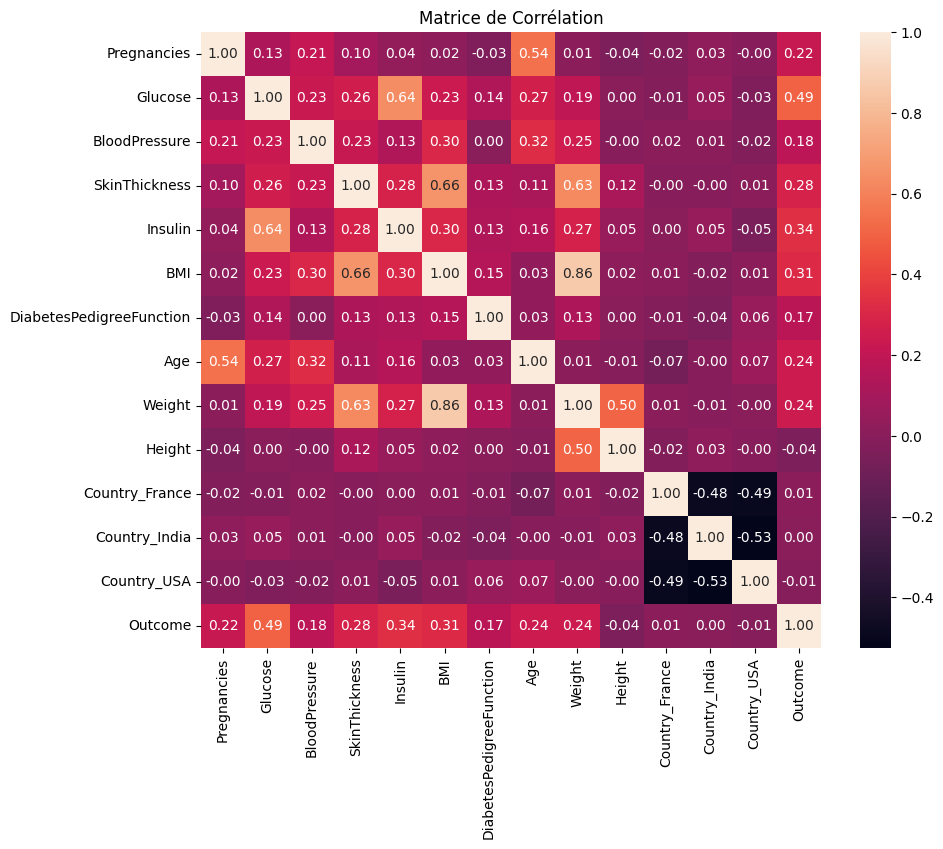

In [37]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_standardized.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Matrice de Corrélation')
plt.show()


#### 🔍 Sélection de Features sur Base de la Matrice de Corrélation
Nous allons utiliser la matrice de corrélation pour analyser les relations entre les variables et sélectionner les plus pertinentes pour notre analyse. Expliquez en la commentant, ce que fait la fonction ci-dessous.

Calculez la corrélation absolue de chaque variable avec Outcome

Triez par ordre décroissant.

Sélectionnez uniquement les variables dont la valeur absolue de corrélation est supérieure à 0,2.

Retournez un DataFrame contenant uniquement ces colonnes (les plus pertinentes pour le target).

In [38]:
def select_features(df):
    corr_target = correlation_matrix['Outcome'].abs().sort_values(ascending=False)
    selected_features = corr_target[corr_target > 0.2].index.tolist()
    print(selected_features)
    return df[selected_features]

df_selected = select_features(df_standardized)
df_selected.head()


['Outcome', 'Glucose', 'Insulin', 'BMI', 'SkinThickness', 'Weight', 'Age', 'Pregnancies']


,Outcome,Glucose,Insulin,BMI,SkinThickness,Weight,Age,Pregnancies
0,1,0.864496,0.536662,0.166748,0.659145,0.417851,1.425995,0.639947
1,0,-1.206083,-0.728840,-0.850846,0.034974,-0.876940,-0.190672,-0.844885
2,1,2.014818,0.871289,-1.330568,-0.443557,-1.487759,-0.105584,1.233880
3,0,-1.074618,-0.572681,-0.632790,-0.589197,-0.107015,-1.041549,-0.844885
4,1,0.502966,0.177697,1.547769,0.659145,1.553994,-0.020496,-1.141852


#### 🔍 Transformation automatique du dataset
La bibliothèque Scikit-learn permet d'écrire des transformateurs maison. Ces derniers permettent de définir soit même les tranformations à apporter à un jeu de données avant utilisation dans un modèle. Ci-dessous, vous trouverez un exemple incomplet de tranformateur. 

1. Complétez la méthode `transform` pour effectuer sur un dataset X l'ensemble des tranformations nécessaires, en vous basant sur les fonctions écritent précedemment.  
2. Appliquez ce transformateur au jeu de données initial.

In [39]:
class DataCleaningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, resampling_method, data_completion_method, outlier_threshold):
        self.resampling_method = resampling_method
        self.data_completion_method = data_completion_method
        self.outlier_threshold = outlier_threshold

    def fit(self, X, y=None):
        return self  
    
    def transform(self, X):
        df = X.copy()
        df = pd.get_dummies(df, columns=['Country'], drop_first=False)

        na_cols = df.columns[df.isna().any()].tolist()
        df = self.data_completion_method(df, na_cols)

        df = remove_outliers(df, self.outlier_threshold)

        df = self.resampling_method(df)

        df = standardisation(df)

        corr_matrix = df.corr()
        corr_target = corr_matrix['Outcome'].abs().sort_values(ascending=False)
        selected_features = corr_target[corr_target > 0.2].index.tolist()
        df_selected = df[selected_features]

        return df_selected

transf = DataCleaningTransformer(oversampling, data_imputation, 2)
df_transformed = transf.transform(df)
df_transformed.head()

,Outcome,Glucose,Insulin,Age,BMI,SkinThickness,Weight,Pregnancies
1,0,-1.347554,-0.912373,-0.099696,-0.983560,0.063871,-1.045508,-0.883960
3,0,-1.202093,-0.679742,-1.151337,-0.723690,-0.663771,-0.085388,-0.883960
5,0,-0.220237,-0.773398,-0.204860,-1.156806,-1.124611,-1.238787,0.453347
10,0,-0.438427,0.401841,-0.204860,0.922152,0.767258,0.931746,0.119020
20,0,0.143414,1.450191,-0.520352,1.216671,1.519154,0.855347,-0.215306
